In [1]:
import os
import pypsa
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import sys 
sys.path.append(os.path.join(os.getcwd(), "..")) 

In [2]:
EXTERNAL = "/Volumes/T9"
PYPSA = os.path.abspath(os.path.join(os.getcwd(), "../..")) + '/pypsa-eur'
RESOURCES = PYPSA + "/resources/"
DATA = PYPSA +  "/data/"
CUTOUT = PYPSA + "/cutouts/"
DEMAND = os.path.abspath(os.path.join(os.getcwd(), "../..")) + '/climate_data/entsoe'

In [3]:
""" demand data from Entsoe (https://www.entsoe.eu/data/power-stats/) 2015-2019 """
load_all = []
demand_filename = DEMAND + f'/MHLV_{2015}-{2017}.xlsx'
load_demand = pd.read_excel(demand_filename, index_col=False) 
load_all.append(load_demand)

demand_filename = DEMAND + f'/MHLV_{2018}-{2019}.xlsx'
load_demand = pd.read_excel(demand_filename, index_col=False) 
load_all.append(load_demand)

load_all = pd.concat(load_all, axis=0, ignore_index=True)

In [4]:
selected_country = 'BE'
network_filename = RESOURCES + f"{selected_country}/networks/elec_s.nc"  
network = pypsa.Network(network_filename)
network.buses['pop_ratio'] = 0 
pop = network.loads_t['p_set'].iloc[1]
network.buses.loc[network.loads_t['p_set'].columns, 'pop_ratio'] = pop/pop.sum()

country_load = load_all[load_all['CountryCode'] == selected_country]
date_list_load = pd.to_datetime(country_load['DateShort'], format='%Y-%m-%d %H:%M')
country_load_value = country_load['Value'].values

INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, loads, storage_units


In [5]:
year_list = [2017,2019]
bus_loc_list = network.buses[['x','y']].values
pop_ratio = network.buses['pop_ratio'].values.reshape(1,-1)

weather_filename =   EXTERNAL + '/era5/demand_cali/Historical_era5_data.nc'
ncfile = xr.open_dataset(weather_filename)
date_s = datetime(year_list[0], 1, 1, 0, 0, 0)
date_e = datetime(year_list[-1]+1, 1, 1, 0, 0, 0)

x_min, x_max = network.buses['x'].min() - 1,  network.buses['x'].max() + 1
y_min, y_max = network.buses['y'].min() - 1,  network.buses['y'].max() + 1
ncfile_slice = ncfile.sel(time=slice(date_s, date_e),x=slice(x_min, x_max ), y=slice(y_min, y_max ))    
date_list = ncfile_slice.time.data
x_da = xr.DataArray(bus_loc_list[:,0], dims=["bus"])
y_da = xr.DataArray(bus_loc_list[:,1], dims=["bus"])
bus_ncfile_slice = ncfile_slice.sel(x=x_da, y=y_da, method="nearest")
bus_ncfile_slice_ave = bus_ncfile_slice[['temperature','wnd10m','influx']].resample(time='1D').mean()
temp_data = bus_ncfile_slice_ave['temperature'].data - 273.15
wind_data = bus_ncfile_slice_ave['wnd10m'].data
solar_data = bus_ncfile_slice_ave['influx'].data
date_list = date_list[::24].astype('datetime64[D]').astype('O')

In [6]:
from utils.data_config import *
training_data_df = pd.DataFrame(columns=['date', 'load'])
hourly_load = []
valid_date = []
for t in range(temp_data.shape[0]):
    year = date_list[t].year
    month = date_list[t].month
    day =  date_list[t].day
    date = datetime(year, month, day)
    day_of_week = date.weekday()
    load_index = (date_list_load.dt.year == year) & \
                    (date_list_load.dt.month == month) & \
                    (date_list_load.dt.day == day) 
    daily_load = country_load_value[load_index]
    if daily_load.shape[0] == 24 and daily_load.min() > 0:
        if [year, month, day] in holiday_list[selected_country][year]:
            holiday_index = 1
        else:
            holiday_index = 0
        valid_date.append(t)
        hourly_load.append(np.reshape(daily_load, (1,-1)))
        training_data_df = training_data_df._append({'date': f'{year}-{month}-{day}', 
                                                    'day_of_week':day_of_week,
                                                    'holiday': holiday_index,
                                                    'load': daily_load.sum() / 1e3 / 24}, ignore_index=True)
valid_date = np.array(valid_date)
hourly_load = np.array(hourly_load)
weekday_index = ((training_data_df['day_of_week']<5) & (training_data_df['holiday']==0)).values.astype(int)
weekend_index = ((training_data_df['day_of_week']>=5) | (training_data_df['holiday']==1)).values.astype(int)
load = training_data_df['load'].values
temp = temp_data[valid_date]
wind = wind_data[valid_date]
solar = solar_data[valid_date]

In [7]:
from pypop7.optimizers.cem.cem import CEM  # abstract class of all cross-entropy method (CEM) classes
class SCEM(CEM):
    def __init__(self, problem, options):
        CEM.__init__(self, problem, options)
        self.alpha = options.get('alpha', 0.8)  # smoothing factor
        assert 0.0 <= self.alpha <= 1.0

    def initialize(self, is_restart=False):
        mean = self._initialize_mean(is_restart)
        x = np.empty((self.n_individuals, self.ndim_problem))  # samples (population)
        y = np.empty((self.n_individuals,))  # fitness (no evaluation)
        return mean, x, y

    def iterate(self, mean=None, x=None, y=None, args=None):
        for i in range(self.n_individuals):
            if self._check_terminations():
                return x, y
            x[i] = mean + self._sigmas*self.rng_optimization.standard_normal((self.ndim_problem,))
            x[i] = np.clip(x[i], self.lower_boundary, self.upper_boundary)
            y[i] = self._evaluate_fitness(x[i], args)
        return x, y

    def _update_parameters(self, mean=None, x=None, y=None):
        xx = x[np.argsort(y)[:self.n_parents]]
        mean = self.alpha*np.mean(xx, axis=0) + (1.0-self.alpha)*mean
        mean = np.clip(mean, self.lower_boundary, self.upper_boundary)
        self._sigmas = self.alpha*np.std(xx, axis=0) + (1.0-self.alpha)*self._sigmas
        return mean

    def optimize(self, fitness_function=None, args=None):
        fitness = CEM.optimize(self, fitness_function)
        mean, x, y = self.initialize()
        while True:
            x, y = self.iterate(mean, x, y, args)
            self._print_verbose_info(fitness, y)
            if self._check_terminations():
                break
            self._n_generations += 1
            mean = self._update_parameters(mean, x, y)
        return self._collect(fitness, y, mean)

In [8]:
from utils.demand_calibration import _bait
def compute_r2(y_data, y_pred):
    ss_res = np.sum((y_data - y_pred) ** 2)
    ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
    r2_score = 1 - (ss_res / ss_tot)
    return r2_score

def compute_rmse(y_data, y_pred):
    return (np.mean((y_data - y_pred)**2))**0.5

def compute_mape(y_data, y_pred):
    return (np.mean(np.abs(y_data - y_pred)/y_data))


xl = np.array([5, 15,   0.019-0.1,      -0.13-0.25,        0.62-0.2,  load.min(),   0])
xu = np.array([15, 25, 0.019+0.1,      -0.13+0.25,        0.62+0.2, load.max(), load.min()])
x_range = np.abs(xu - xl)
def fitness_function(x):
    Th, Tc, solar_gains,wind_chill,smoothing,Pb,alpha = x * x_range
    # Th = demand_model_para[selected_country]['heating_threshold']
    # Tc = demand_model_para[selected_country]['cooling_threshold']
    Ph = demand_model_para[selected_country]['p_heating']
    Pc = demand_model_para[selected_country]['p_cooling']

    para = {}
    para['solar_gains'] = solar_gains
    para['wind_chill'] = wind_chill
    para['humidity_discomfort'] = 0.05
    para['smoothing'] = smoothing
    bait = _bait(temp, wind, solar, para)
    bait = (bait* pop_ratio).sum(-1)
    demand = Pb + Ph * np.maximum(Th - bait, 0)  + Pc * np.maximum(bait - Tc, 0) + alpha * weekday_index
    return compute_mape(load, demand)#(np.abs(demand - load)**2).mean()


In [9]:
problem = {'fitness_function': fitness_function,  # define problem arguments
           'ndim_problem': 7,
           'lower_boundary': xl/x_range,
           'upper_boundary': xu/x_range}
options = {'max_function_evaluations': 50000,  # set optimizer options
           'seed_rng': 8888,
           'mean': (xl+xu)/2/x_range,  # initial mean of Gaussian search distribution
           'alpha': 0.9,
           'sigma': 0.3}  # initial std (aka global step-size) of Gaussian search distribution
opt = SCEM(problem, options)  # initialize the optimizer class
results = opt.optimize()  # run the optimization process
# return the number of function evaluations and best-so-far fitness
print(f"{selected_country}: {results['n_function_evaluations']}, {results['best_so_far_y']}", results['best_so_far_x'])

  * Generation 0: best_so_far_y 4.03923e-02, min(y) 4.03923e-02 & Evaluations 1000
  * Generation 10: best_so_far_y 3.25323e-02, min(y) 3.25323e-02 & Evaluations 11000
  * Generation 20: best_so_far_y 3.24673e-02, min(y) 3.24673e-02 & Evaluations 21000
  * Generation 30: best_so_far_y 3.24654e-02, min(y) 3.24654e-02 & Evaluations 31000
  * Generation 40: best_so_far_y 3.24652e-02, min(y) 3.24652e-02 & Evaluations 41000
  * Generation 49: best_so_far_y 3.24651e-02, min(y) 3.24651e-02 & Evaluations 50000
BE: 50000, 0.032465092351861846 [1.41922636 2.49999952 0.17962084 0.13452354 1.25460568 1.63880907
 0.18092957]


/Users/liangenming/opt/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/liangenming/opt/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


0.03110095129418315 0.4352208679310275
0.035491498009625866 0.40993678999868616
0.032465092351861846 0.42752526756517023


(array([ 7.,  8.,  9., 10., 11., 12., 13.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

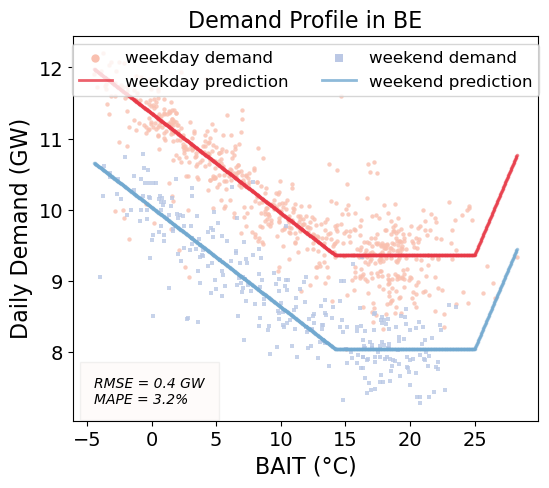

In [10]:
Th, Tc, solar_gains,wind_chill,smoothing,Pb,alpha = results['best_so_far_x'] * x_range
# Th = demand_model_para[selected_country]['heating_threshold']
# Tc = demand_model_para[selected_country]['cooling_threshold']
Ph = demand_model_para[selected_country]['p_heating']
Pc = demand_model_para[selected_country]['p_cooling']
para = {}
para['solar_gains'] = solar_gains
para['wind_chill'] = wind_chill
para['humidity_discomfort'] = 0.05
para['smoothing'] = smoothing
bait = _bait(temp, wind, solar, para)
bait = (bait* pop_ratio).sum(-1)

demand_model_para[selected_country]['solar_gains'] = solar_gains
demand_model_para[selected_country]['wind_chill'] = wind_chill
demand_model_para[selected_country]['smoothing'] = smoothing
demand_model_para[selected_country]['base_demand'] = Pb
demand_model_para[selected_country]['workday_demand'] = alpha

weekday_cooling_hour_ratio = np.mean(hourly_load[(weekday_index==1) & (bait >= Tc)] - Pb, axis=0)
weekend_cooling_hour_ratio = np.mean(hourly_load[(weekday_index==0) & (bait >= Tc)] - Pb, axis=0)
weekday_heating_hour_ratio = np.mean(hourly_load[(weekday_index==1) & (bait <= Th)] - Pb, axis=0)
weekend_heating_hour_ratio = np.mean(hourly_load[(weekday_index==0) & (bait <= Th)] - Pb, axis=0)

demand_model_para[selected_country]['weekday_cooling_hour_ratio'] = weekday_cooling_hour_ratio / weekday_cooling_hour_ratio.sum()
demand_model_para[selected_country]['weekend_cooling_hour_ratio'] = weekend_cooling_hour_ratio / weekend_cooling_hour_ratio.sum()
demand_model_para[selected_country]['weekday_heating_hour_ratio'] = weekday_heating_hour_ratio / weekday_heating_hour_ratio.sum()
demand_model_para[selected_country]['weekend_heating_hour_ratio'] = weekend_heating_hour_ratio / weekend_heating_hour_ratio.sum()

plt.figure(figsize=[6,5])

weekday_bait = bait[weekday_index==1]
weekend_bait = bait[weekday_index==0]
demand = Pb + Ph * np.maximum(Th - bait, 0)  + Pc * np.maximum(bait - Tc, 0) + alpha * weekday_index
plt.scatter(weekday_bait, load[weekday_index==1], marker='o', c=lred, linewidth=0, alpha=0.8,s=10)
plt.scatter(weekend_bait, load[weekday_index==0], marker='s', c=lblue, linewidth=0, alpha=0.8,s=10)

weekday_demand_pred = Pb + Ph * np.maximum(Th - weekday_bait, 0)  + Pc * np.maximum(weekday_bait - Tc, 0) + alpha * 1
weekend_demand_pred = Pb + Ph * np.maximum(Th - weekend_bait, 0)  + Pc * np.maximum(weekend_bait - Tc, 0) + alpha * 0
pred_load = np.zeros(load.shape)
pred_load[weekday_index==1] = weekday_demand_pred
pred_load[weekday_index==0] = weekend_demand_pred
print(compute_mape(load[weekday_index==1], weekday_demand_pred), compute_rmse(load[weekday_index==1], weekday_demand_pred))
print(compute_mape(load[weekday_index==0], weekend_demand_pred), compute_rmse(load[weekday_index==0], weekend_demand_pred))
print(compute_mape(load, pred_load), compute_rmse(load, pred_load))
plt.text(bait.min(), load.min(), 
         f'RMSE = {compute_rmse(load, pred_load):.1f} GW\nMAPE = {compute_mape(load, pred_load)*100:.1f}%', 
          style='italic',
        bbox={'facecolor': lred, 'alpha': 0.05, 'pad': 10})

bait_simu = np.linspace(bait.min(),bait.max(),1000)
work_demand = Pb + Ph * np.maximum(Th - bait_simu, 0)  + Pc * np.maximum(bait_simu - Tc, 0) + alpha * 1
week_demand = Pb + Ph * np.maximum(Th - bait_simu, 0)  + Pc * np.maximum(bait_simu - Tc, 0) + alpha * 0

plt.scatter(bait_simu, work_demand, marker='.', alpha=0.5, c=red, s=10)
plt.scatter(bait_simu, week_demand, marker='.', alpha=0.5, c=blue, s=10)

plt.scatter([],[], marker='o', c=lred, linewidth=0, alpha=0.99, label='weekday demand')
plt.plot([],[], alpha=0.8, c=red, linewidth=2, label='weekday prediction')

plt.scatter([],[], marker='s', c=lblue, linewidth=0, alpha=0.99, label='weekend demand')
plt.plot([],[], alpha=0.8, c=blue, linewidth=2, label='weekend prediction')
plt.legend(ncol=2, loc=9, fontsize=12)
plt.title(f'Demand Profile in {selected_country}', fontsize=16)
plt.ylabel('Daily Demand (GW)', fontsize=16)
plt.xlabel('BAIT (°C)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)